# Introdução a Séries Temporais

Tutorial for improve skills: 'Séries Temporais com python/pandas/statsmodels - Parte 06' (ORMaster) by Marcus Mariano

**For more information about Marcus Mariano: [Web site](https://marcusmariano.github.io/mmariano/)**  

**Séries Temporais com python/pandas/statsmodels - Parte 01 [ORMaster.](https://www.youtube.com/playlist?list=PL5fQ3JoS0SZscDaHgXahtx632NMnq5RR-)** 

**ronaldolagepessoa: [GitHub.](https://github.com/ronaldolagepessoa/timeseries)**

## Load packages

In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Set parameters

In [3]:
N_THREADS = 6 # threads cnt for lgbm and linear models
N_FOLDS = 10 # folds cnt for AutoML
N_JOBS = -1 # -1 means using all processors
SEED = 0 # fixed random state for various reasons
TEST_SIZE = 0.3 # Test size for metric check
VERBOSE = 1
EPOCHS = 50
TIMEOUT = 600 # Time in seconds for automl run, 600 seconds = 10 minutes
RAM = 16 #  Number of RAM limit
CPU_LIMIT = 16 # Number of CPU limit
TARGET_NAME = 'CHURN'

## Modelo Integrado Auto-regressivo de Média Móveis (ARIMA)
ARIMA é a acrônimo que significa "Autoregressive Integrated Moving Average Model" (Modelo de médias móveis integrado de auto regressivo).

Esse acrônimo é descritivo, capturando os aspectos chave do próprio modelo. Resumidamente, estes são:

* AR: Auto regressão. Um modelo que utiliza a relação de dependência entre uma observação e um conjunto de observações passadas.
* I: Integrated. O uso de diferenças das obervações para tornar uma série estacionária.
* MA: Média móvel. Um modelo que usa a dependência entre uma observação e o erro residual das média móveis aplicadas em observações anteriores. 

Cada um desses componentes são explicitamente especificados no modelo através de parâmetros. Uma notação padrão é utilizada como ARIMA($p, d, q$), onde os parâmetros são substituidos por valores inteiros para indicar o modelo ARIMA específico que está sendo utilizado. 

Os parâmetros do modelo ARIMA são definidos como:

* p: o número de observações passadas inclusas no modelo, também chamado de "ordem do lag".
* d: o número de diferenças tomadas, também chamado de "grau de diferenciação"
* q: o tamanho da janela da média móvel, também chamado de "ordem da média móvel"

A vantagem do modelo ARIMA em relação ao modelo ARMA está na possibilidade de trabalhar com séries não estacionárias. Tomemos o exemplo das informações contidas no arquivo ```clima_india.csv```.

In [4]:
Path = ""

data = pd.read_csv(Path+"data/clima_india.csv")
print(data.shape)
data.head()

(1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [5]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [6]:
train = data.copy()

In [7]:

train.date = pd.to_datetime(data.date)
train.set_index('date', inplace=True)
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


Analisando o comportamento da śérie temporal das temperaturas médias ```meantemp```, observamos um padrão não estacionário.

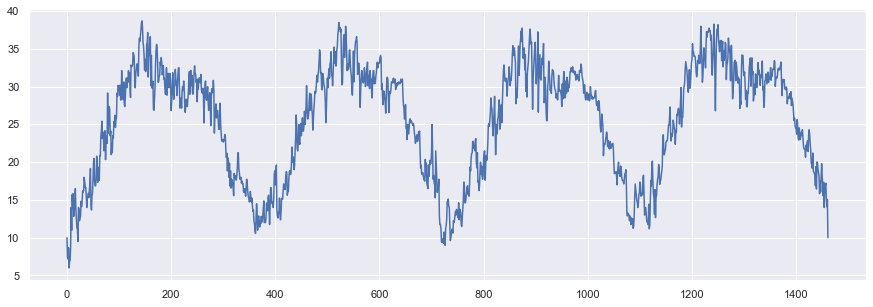

In [8]:
data.meantemp.plot(figsize=(15, 5));

A tentativa de aplicar o modelo ARMA em uma série não estacionária resultará em erros de ajusto do modelo, uma vez que este assume que a série possui comportamento aleatório normal com parâmetros constantes, i.e. $\epsilon_t \sim  N(0, \sigma^2)$ e $E(X_t) = \mu \;\forall t$.

Configurando o parâmetro $d>0$ no modelo ARIMA($p, d, q$), obtemos o cálculo das disferenças sucessivas na série, transformando a mesma em uma séries estacionária. 

No exemplo da temperatura média, aplicaremos a primeira diferença ($d=1$) para demonstrar o efeito da operação utilizando o comando ```Series.diff()```.

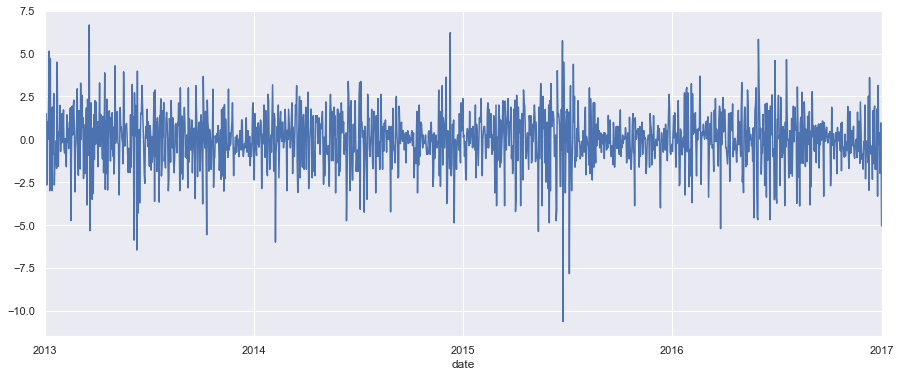

In [10]:
train.meantemp.diff().plot(figsize=(15, 6));

Faremos agora a importação da classe ARIMA contida no subpacote ```statsmodels.tsa.arima_model```. Para criar o modelo, utilizaremos o comando ```ARIMA(Series, freq='frequencia_da_serie', order=(p, d, q)).fit()```.

Para o parâmetro ```order```, faremos a configuração ```(5, 1, 2)```, representando a componente autoregressiva com lag igual a 5, uma diferença sucessiva para garantir a estacionaridade da série e 2 períodos para a componente de erros móveis.

In [11]:
from statsmodels.tsa.arima_model import ARIMA

arima = ARIMA(train.meantemp, freq='D', order=(5, 1, 2)).fit()

Para gerar as previsões do modelo utilizando o comando ```predict()```, precisamos passar o parâmetro ```typ='levels'``` para reverter as diferêncas sucessivas aplicadas. Caso contrário, teríamos as previsões das disferenças. 

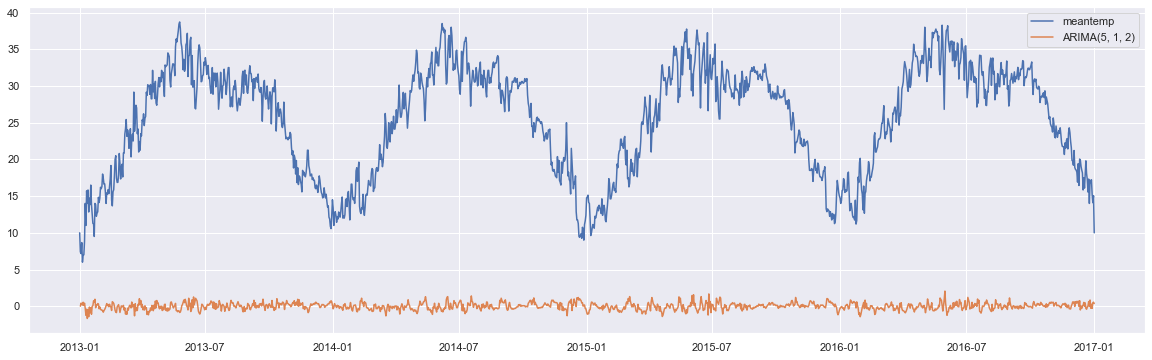

In [42]:
plt.figure(figsize=(20, 6))
plt.plot(train.meantemp)
plt.plot(arima.predict())
plt.legend(['meantemp', 'ARIMA(5, 1, 2)']);

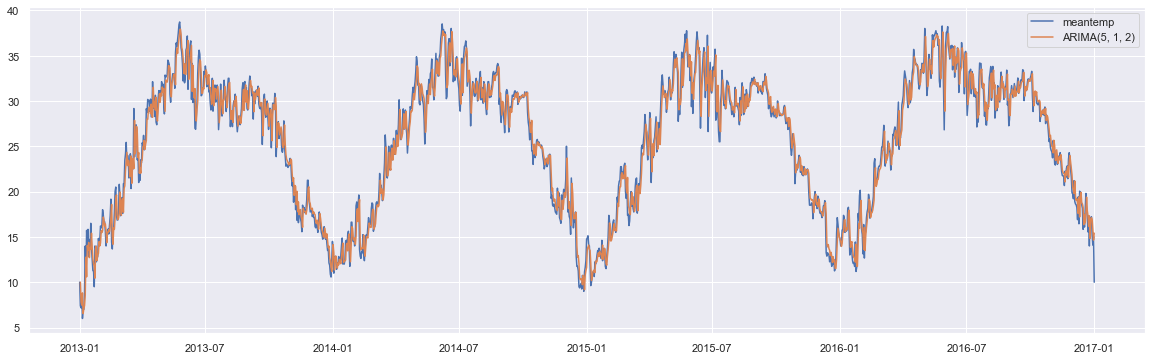

In [12]:
plt.figure(figsize=(20, 6))
plt.plot(train.meantemp)
plt.plot(arima.predict(typ='levels'))
plt.legend(['meantemp', 'ARIMA(5, 1, 2)'])

In [26]:
np.std(arima.predict())
# arima.predict(typ='levels')

0.47459078664652443

In [22]:
# (forecast, standard error, (confidence interval))
arima.forecast(alpha=0.05)

(array([11.37411857]), array([1.6018207]), array([[ 8.23460769, 14.51362945]]))

In [23]:
arima.forecast(alpha=0.05)[0]

array([11.37411857])

In [21]:
# confidence interval
11.37411857 - (1.6018207 * 2), 11.37411857 + (1.6018207 * 2)

(8.17047717, 14.57775997)

In [31]:
orders = [(2, 0, 1), (3, 0, 1), (3, 0, 2), (2, 1, 1), (3, 1, 1), (3, 1, 2), (3, 1, 3)]
# orders = [(2, 1, 1), (3, 1, 1), (3, 1, 2), (3, 1, 3)]

best = 10000
for order in orders:
    try:       
        model = ARIMA(train.meantemp, freq='D', order=order).fit()
        
        erro = (model.resid ** 2).mean()
        if erro < best:
            print(f'ARIMA{order}, erro={erro}')
            best = erro
    except:        
        pass
#         print(f'No ARIMA')

ARIMA(2, 0, 1), erro=2.6787330320690215
ARIMA(3, 0, 1), erro=2.6780927462221222


C:\Users\marcu\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1), erro=2.589471419921525
ARIMA(3, 1, 1), erro=2.5804988670545748
ARIMA(3, 1, 2), erro=2.5782278943931014
ARIMA(3, 1, 3), erro=2.5780772865407204


In [32]:
size = int(len(train.meantemp) * 2/3)
X_train = train.wind_speed[:size]
X_valid = train.wind_speed[size:]

X_train.shape, X_valid.shape

((974,), (488,))

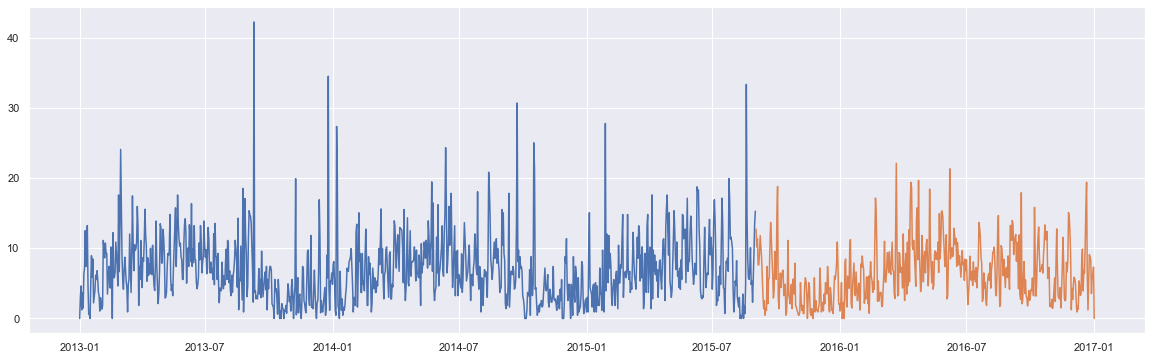

In [34]:
plt.figure(figsize=(20, 6))

plt.plot(X_train)
plt.plot(X_valid)

In [36]:
orders = [(2, 0, 1), (3, 0, 1), (3, 0, 2), (2, 1, 1), (3, 1, 1), (3, 1, 2), (3, 1, 3)]
# orders = [(2, 1, 1), (3, 1, 1), (3, 1, 2), (3, 1, 3)]

best = 10000
for order in orders:
    try:
        model_train = ARIMA(X_train, freq='D', order=order).fit()
        model_valid = ARIMA(X_valid, freq='D', order=order).fit(model_train.params)        
        
        erro = (model_valid.resid ** 2).mean()
        
#         print(f'ARIMA{order}, erro={erro}')
        if erro < best:
            print(f'ARIMA{order}, erro={erro}')
            best = erro
    except:        
        pass
#         print(f'No ARIMA')

ARIMA(2, 0, 1), erro=11.02301329573653
ARIMA(3, 0, 1), erro=10.90271152419474


C:\Users\marcu\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


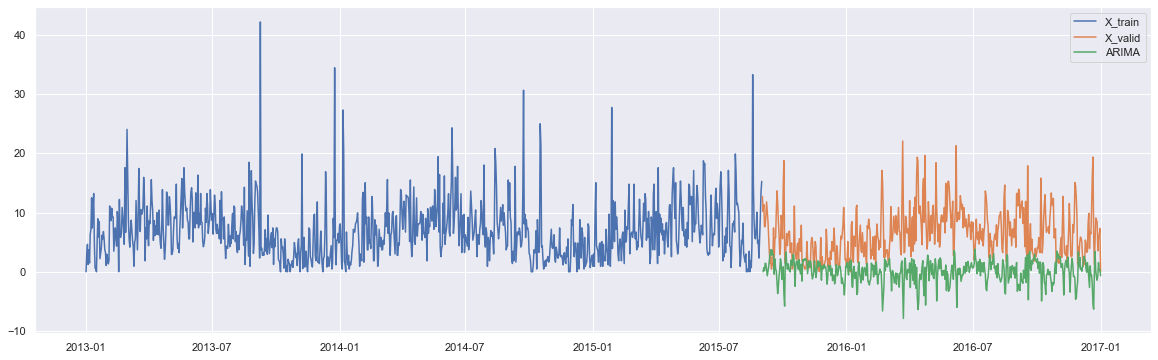

In [41]:
plt.figure(figsize=(20, 6))

plt.plot(X_train)
plt.plot(X_valid)
plt.plot(model_valid.predict())
plt.legend(['X_train', 'X_valid', 'ARIMA']);